# Hierarchical Clustering

In [55]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, davies_bouldin_score
import sys
sys.path.append('../')
from utils import center_and_scale
from matplotlib import pyplot as plt

## Cyclist Dataset

In [56]:
cyclists_df = pd.read_csv('../dataset/cyclists_outlier.csv')

### Preprocessing

In [57]:
columns_to_keep = ["avg_relative_position", "mean_sq", "career_level"]

# drop the unnecessary columns for the clustering and keep only the numerical columns 
numerical_cyclists_df = cyclists_df[columns_to_keep]
numerical_cyclists_df

,avg_relative_position,mean_sq,career_level
0,0.004726,1615.878378,14371.866873
1,0.010415,775.122449,1514.222579
2,0.007259,1052.086957,8115.442081
3,0.009004,784.895833,1673.263534
4,0.008623,972.963542,11460.308567
...,...,...,...
3471,0.005587,1021.305648,13654.562144
3472,0.007723,863.183673,2179.182843
3473,0.006247,1164.818182,858.492493
3474,0.012301,676.653846,787.168167


We normalize the data.

In [58]:
scaler = StandardScaler()
scaler = scaler.fit(numerical_cyclists_df)
scaled_cyclists_df = scaler.transform(numerical_cyclists_df)

### Clustering 
We perform the agglomerative hirarchical clustering.

In [59]:
results = []
for metric in ['cityblock','correlation', 'cosine', 'euclidean']:
    methods = ['complete','single','average','weighted']
    if metric == 'euclidean':
        methods += ['ward','median','centroid']
    for method in methods:
        for k in [3, 4, 5, 6, 10]:
            distances = pdist(scaled_cyclists_df, metric=metric)
            dlinkage = linkage(distances, metric=metric, method=method)
            labels = fcluster(dlinkage,k,criterion='maxclust')
            silhouette = silhouette_score(scaled_cyclists_df, labels)
            bouldin = davies_bouldin_score(scaled_cyclists_df, labels)
            #print(f"metric: {metric}, method:{method}, level':{level}, k:{k}, silhouette: {silhouette} , DBscore:{bouldin}")
            results.append({'metric':metric, 'method':method, 'k':k, 'silhouette': silhouette, 'DBscore':bouldin})

results_df = pd.DataFrame(results)

In [60]:
# Order the results by the best silhouette score and then by the highest DB score if silhouette scores are the same
results_df = results_df.sort_values(by=['silhouette', 'DBscore'], ascending=[False, True]).reset_index(drop=True)

# show results
results_df.head(20)


,metric,method,k,silhouette,DBscore
0,cityblock,average,3,0.399006,0.871400
1,euclidean,ward,3,0.387177,0.815194
2,euclidean,complete,3,0.383285,0.774751
3,euclidean,average,3,0.374983,0.747606
4,cosine,average,3,0.372981,0.963970
5,cityblock,average,4,0.365809,0.859583
6,euclidean,median,3,0.359395,0.895596
7,correlation,average,3,0.359152,1.096950
8,cosine,average,4,0.304937,1.020481
9,euclidean,average,4,0.303101,1.007597


In [61]:
# from pytest import mark
# import seaborn as sns

# # Pick the first 15 elements of results_df
# top_15_results = results_df.head(15)

# # Plot pairplots of cluster labels for each element of top_15_results
# for index, row in top_15_results.iterrows():
#     distances = pdist(scaled_cyclists_df, metric=row['metric'])
#     dlinkage = linkage(distances, metric=row['metric'], method=row['method'])
#     labels = fcluster(dlinkage, row['k'], criterion='maxclust')
#     plot_df['Cluster'] = labels
#     sns.pairplot(plot_df, hue='Cluster', palette='viridis', markers='o', plot_kws={'alpha':0.7, 's': 10})
#     plt.title(f"Metric: {row['metric']}, Method: {row['method']}, k: {row['k']}")
#     plt.show()

In [62]:
result_choice = results_df.iloc[7] #7
result_choice

metric        correlation
method            average
k                       3
silhouette       0.359152
DBscore           1.09695
Name: 7, dtype: object

In [63]:

distances = pdist(scaled_cyclists_df, metric=result_choice['metric'])
dlinkage = linkage(distances, metric=result_choice['metric'], method=result_choice['method'])
labels = fcluster(dlinkage, result_choice['k'], criterion='maxclust')

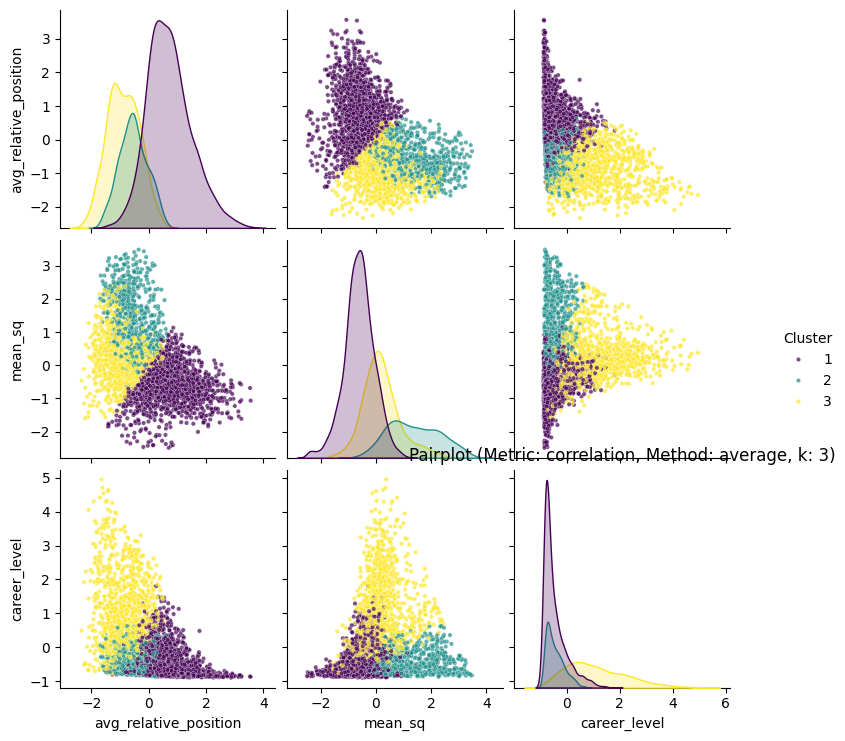

In [64]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame(scaled_cyclists_df, columns=columns_to_keep)
plot_df['Cluster'] = labels

# Plot pairplot
sns.pairplot(plot_df, hue='Cluster', palette='viridis', markers='o', plot_kws={'alpha':0.7, 's': 10})
plt.title(f"Pairplot (Metric: {result_choice['metric']}, Method: {result_choice['method']}, k: {result_choice['k']})")
plt.show()

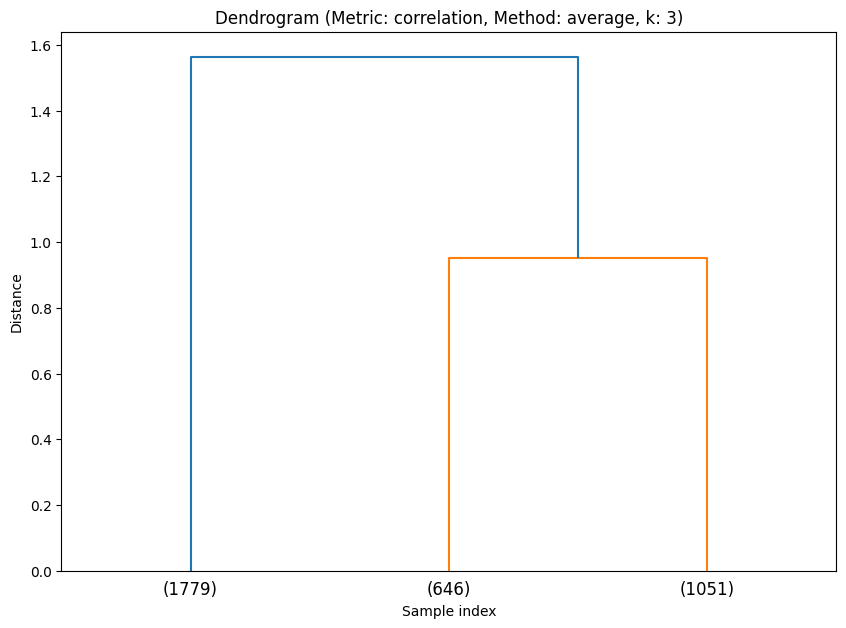

In [65]:
plt.figure(figsize=(10, 7))
plt.title(f"Dendrogram (Metric: {result_choice['metric']}, Method: {result_choice['method']}, k: {result_choice['k']})")
dendrogram(dlinkage, labels=labels, truncate_mode='lastp', p=3)
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [66]:
import numpy as np

# Calculate the centroids of the clusters
centroids = np.array([scaled_cyclists_df[labels == i].mean(axis=0) for i in range(1, result_choice['k'] + 1)])
print(centroids)

[[ 0.71966645 -0.6111226  -0.47061039]
 [-0.54003414  1.37567958 -0.45375982]
 [-0.88622699  0.18886594  1.0754945 ]]


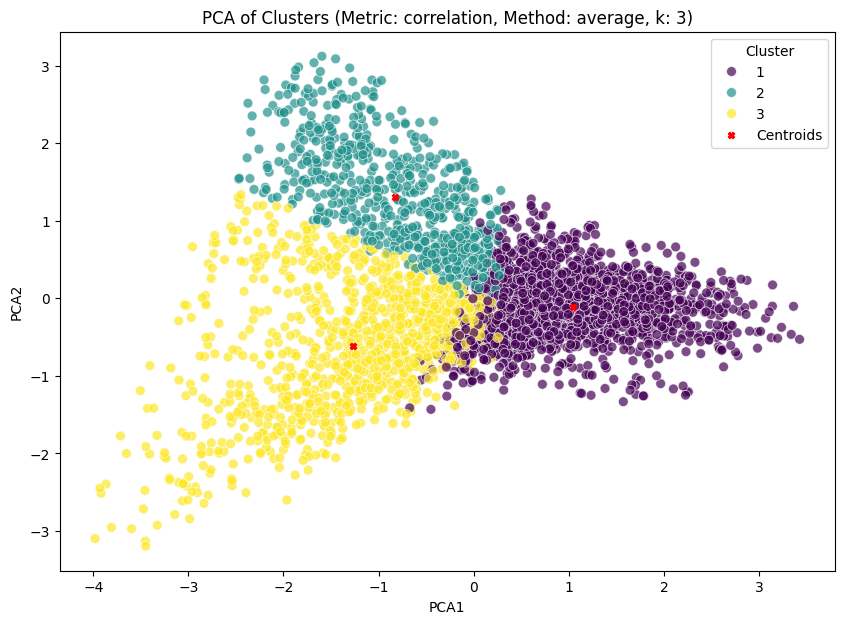

In [67]:
# Perform PCA on the scaled data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_cyclists_df)

# Create a DataFrame with the PCA results and the cluster labels
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = labels

# Calculate the centroids of the clusters in the PCA space
pca_centroids = np.array([pca_df[pca_df['Cluster'] == i][['PCA1', 'PCA2']].mean(axis=0) for i in range(1, result_choice['k'] + 1)])

# Plot the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7, s=50)
plt.scatter(pca_centroids[:, 0], pca_centroids[:, 1], c='red', marker='X', s=20, label='Centroids')
plt.title(f"PCA of Clusters (Metric: {result_choice['metric']}, Method: {result_choice['method']}, k: {result_choice['k']})")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

In [80]:
n_clusters = len(np.unique(labels))
# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(1, n_clusters + 1):
    occ_list.append(np.count_nonzero(np.array(labels) == k))

print('cluster sizes:', occ_list)

cluster sizes: [1779, 646, 1051]


#### **Pie chart**

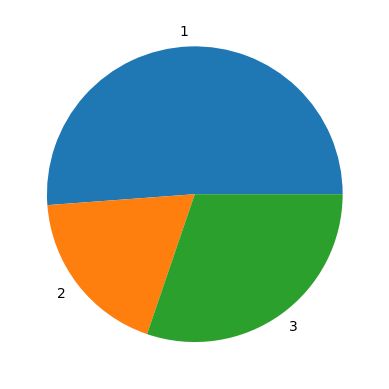

In [82]:
import seaborn as sns

# Ensure labels are unique and match the length of occ_list
unique_labels = np.unique(labels)
plt.pie(occ_list, labels=unique_labels, colors=sns.color_palette(n_colors=len(occ_list)))
plt.show()

#### **Radar Plot**

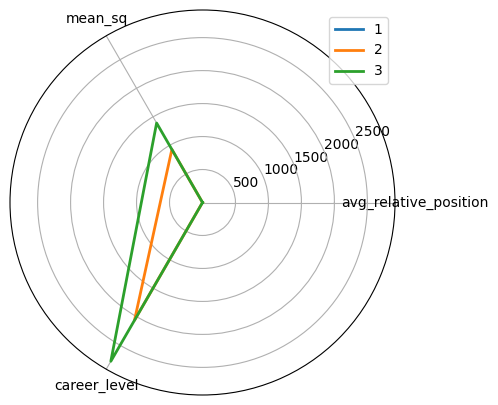

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import math

N = len(numerical_cyclists_df.columns)
plt.figure(figsize=(5, 5))

for k in range(0, n_clusters):
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
     
    values = numerical_cyclists_df[labels== k].median().values.tolist()
    values += values[:1]
    angles += angles[:1]
    ax = plt.subplot(polar=True)
    plt.xticks(angles[:-1], numerical_cyclists_df.columns)
    ax.plot(angles, values, linewidth=2)


plt.legend(labels=np.unique(labels))

plt.show()

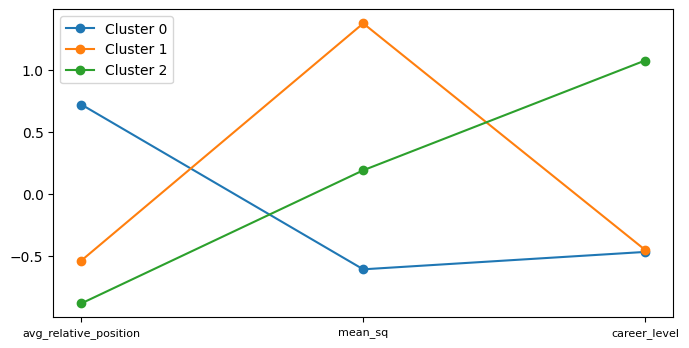

In [68]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(8, 4))
for i in range(0, len(centroids)):
    plt.plot(centroids[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(columns_to_keep)), columns_to_keep, fontsize=8)
plt.legend(fontsize=10)
plt.show()

From these first overview, we advance the hypothesis that:
- **Cluster 0** includes cyclists with a relatively low career level, since the associated mean startlist quality is the lowest and the average relative position is the highest.
- **Cluster 1**: for a slightly higher career level than that associated with cyclists in Cluster 0, we have cyclists with a higher average startlist quality, the highest in the selected clustering. Logically, it also coincides with a better positioning than cyclists in the Cluster 0.
- **Cluster 2**: for a higher career level than that associated with cyclists in Cluster 1, we have cyclists with a lower average startlist quality than that of Cluster 1, but higher than that of Cluster 0. The average relative position is also lower which is logically correct. 

Apparently, the only discrepancy we find is related to the average startlist quality. We would have expected similar results but exchanged between Cluster 1 and Cluster 2. Non è detto che un ciclista forte debba avere una mean sq alta.


In [74]:
cluster_labels = {0: 'Unexperienced Cyclists', 1: 'Medium Cyclists', 2: 'Best Cyclists'}

In [76]:
# filter the dataframe for each cluster value
unexperienced_cyclists = cyclists_df[labels == 1]
medium_cyclists = cyclists_df[labels == 2]
best_cyclists = cyclists_df[labels == 3]

#### **Characterization based on** ```weighted_podiums```

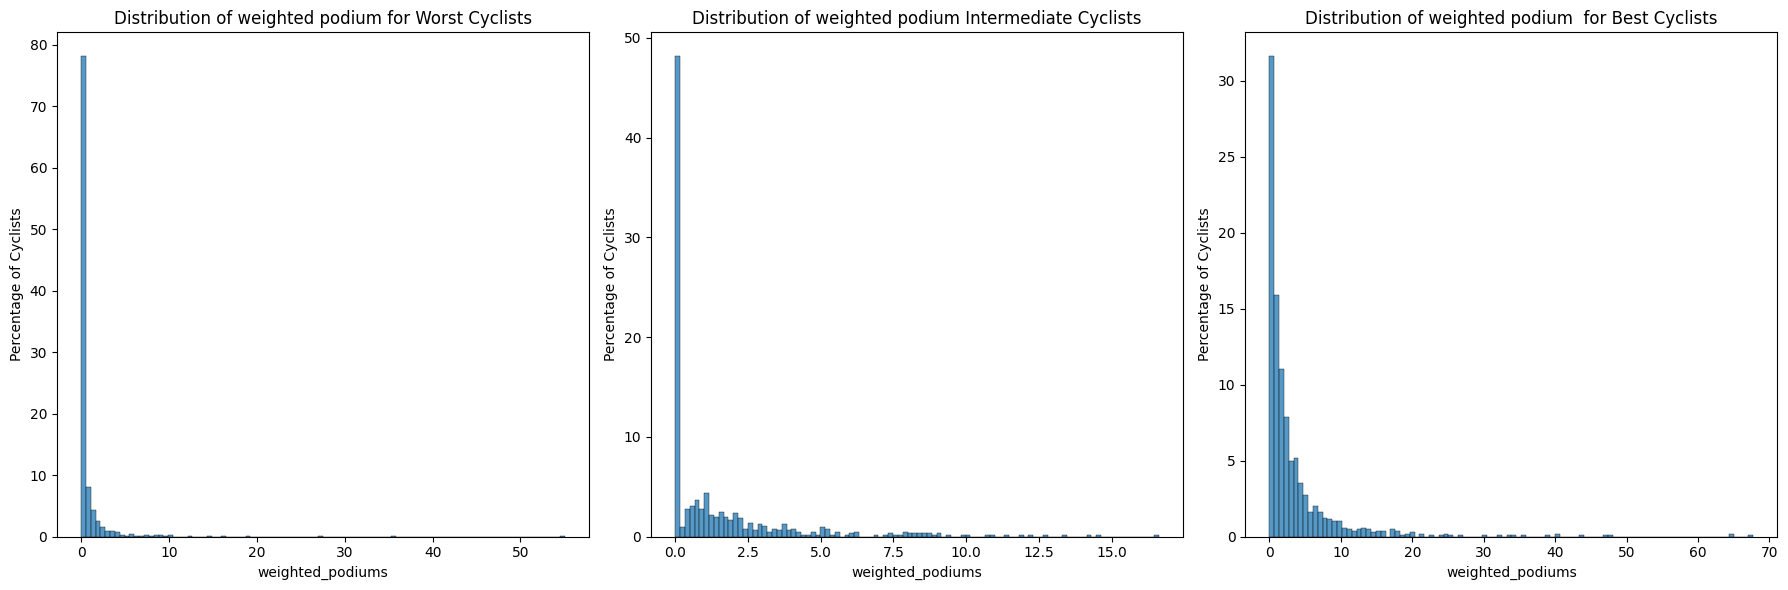

In [78]:
# Plot the distribution of stages won for all clusters
plt.figure(figsize=(18, 6))

# Plot for worst cyclists
plt.subplot(1, 3, 1)
sns.histplot(unexperienced_cyclists['weighted_podiums'], bins=100, stat='percent')
plt.title('Distribution of weighted podium for Worst Cyclists')
plt.xlabel('weighted_podiums')
plt.ylabel('Percentage of Cyclists')

# Plot for intermediate cyclists
plt.subplot(1, 3, 2)
sns.histplot(medium_cyclists['weighted_podiums'], bins=100, stat='percent')
plt.title('Distribution of weighted podium Intermediate Cyclists')
plt.xlabel('weighted_podiums')
plt.ylabel('Percentage of Cyclists')

# Plot for best cyclists
plt.subplot(1, 3, 3)
sns.histplot(best_cyclists['weighted_podiums'], bins=100, stat='percent')
plt.title('Distribution of weighted podium  for Best Cyclists')
plt.xlabel('weighted_podiums')
plt.ylabel('Percentage of Cyclists')

plt.tight_layout()
plt.show()

These distributions suggest that the weighted podiums score is highly discriminative among the three groups. Worst Cyclists almost always have low scores, while Best Cyclists show greater variability and achieve higher scores. Intermediate Cyclists are in an intermediate range, with some overlap with both other groups.

#### **Characterization based on** ```cyclist_experience_points```

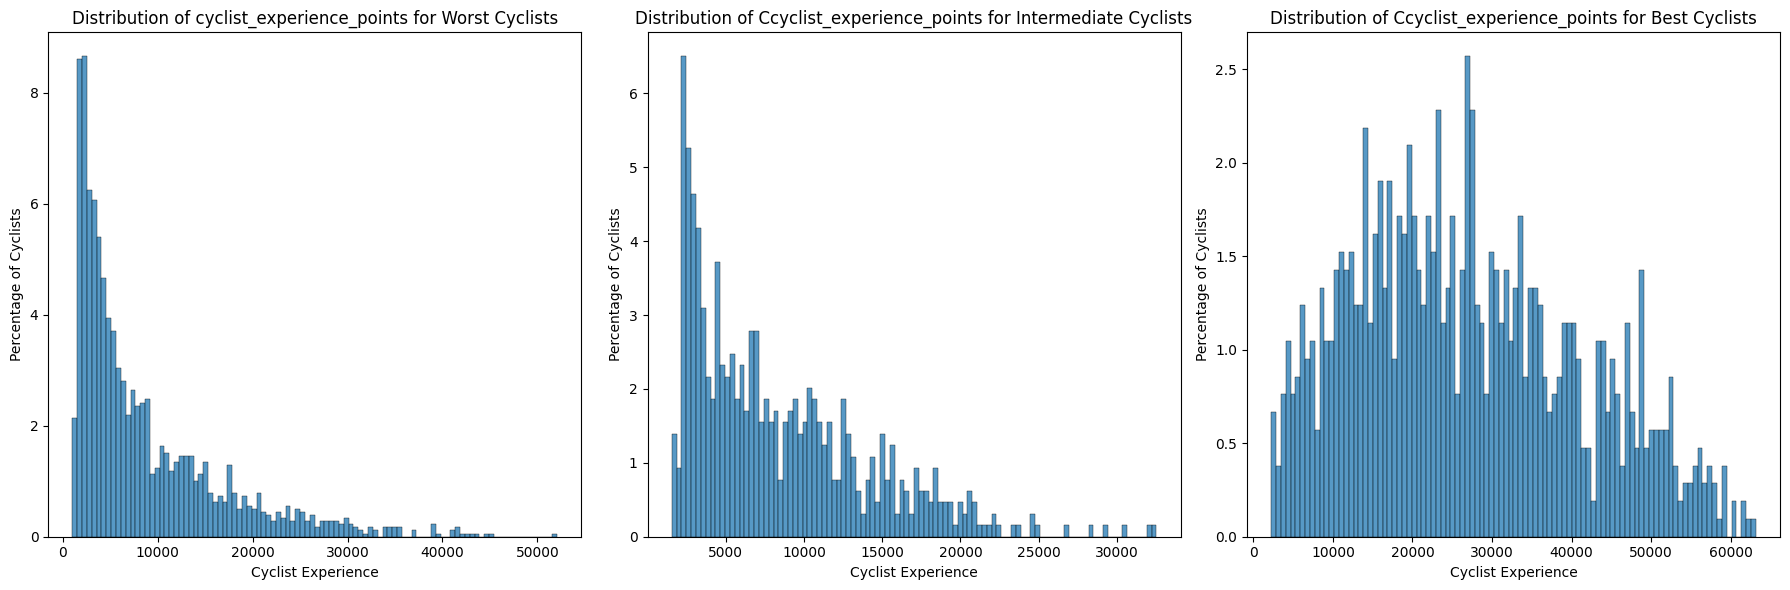

In [ ]:
# Plot the normalized distribution of cyclist experience points for all clusters
plt.figure(figsize=(18, 6))

# Plot for worst cyclists
plt.subplot(1, 3, 1)
sns.histplot(unexperienced_cyclists['cyclist_experience_points'], bins=100, stat='percent')
plt.title('Distribution of cyclist_experience_points for Worst Cyclists')
plt.xlabel('Cyclist Experience')
plt.ylabel('Percentage of Cyclists')

# Plot for intermediate cyclists
plt.subplot(1, 3, 2)
sns.histplot(medium_cyclists['cyclist_experience_points'], bins=100, stat='percent')
plt.title('Distribution of Ccyclist_experience_points for Intermediate Cyclists')
plt.xlabel('Cyclist Experience')
plt.ylabel('Percentage of Cyclists')

# Plot for best cyclists
plt.subplot(1, 3, 3)
sns.histplot(best_cyclists['cyclist_experience_points'], bins=100, stat='percent')
plt.title('Distribution of Cyclist_experience_points for Best Cyclists')
plt.xlabel('Cyclist Experience')
plt.ylabel('Percentage of Cyclists')

plt.tight_layout()
plt.show()


I Worst Cyclists sono caratterizzati da esperienza molto limitata, con poca variabilità tra i membri del gruppo. Gli Intermediate Cyclists hanno una gamma più ampia di esperienza, con una concentrazione nei livelli medio-bassi. I Best Cyclists dimostrano esperienza significativa, con una distribuzione che riflette un livello di maturità ed esperienza avanzato nella popolazione.

#### **Characterization based on** ```performance_entropy```

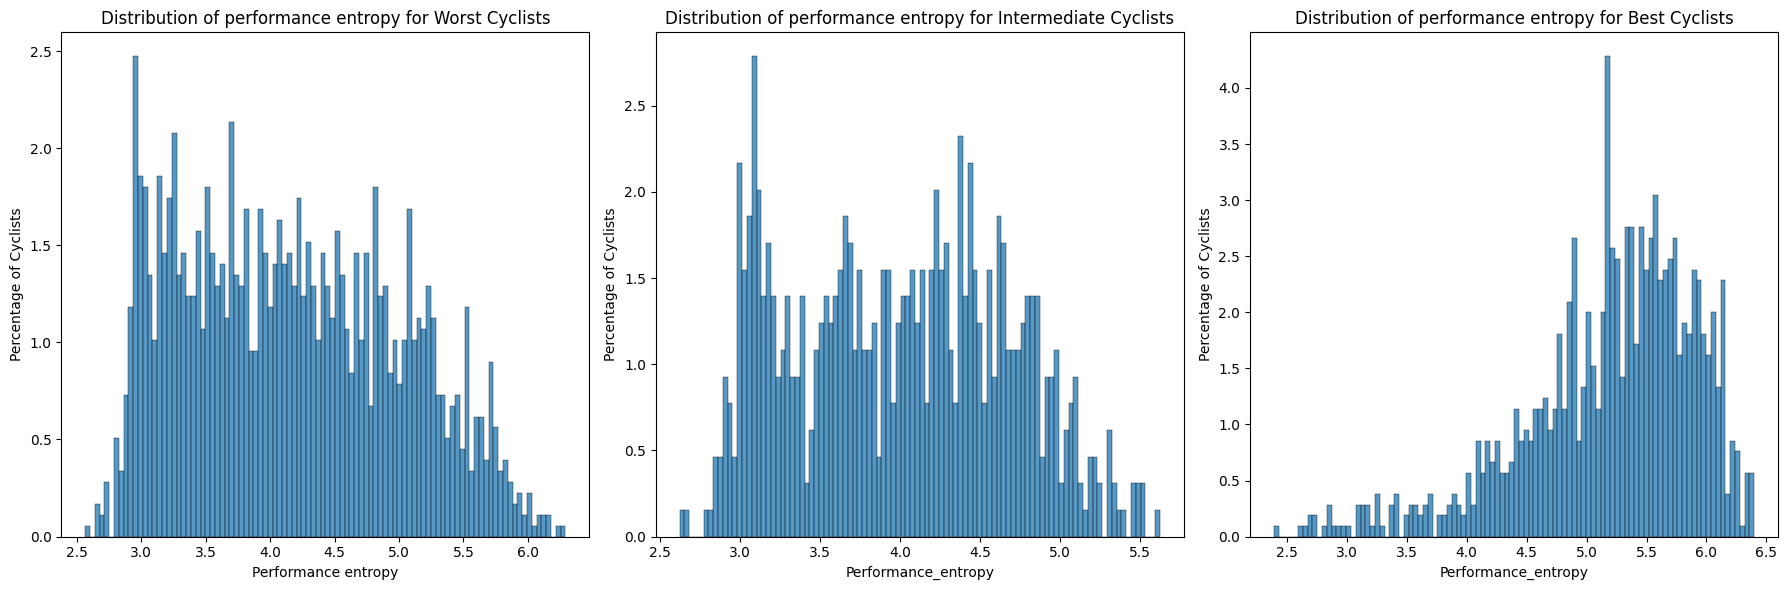

In [84]:
plt.figure(figsize=(18, 6))

# Plot for worst cyclists
plt.subplot(1, 3, 1)
sns.histplot(unexperienced_cyclists['performance_entropy'], bins=100, stat='percent')
plt.title('Distribution of performance entropy for Worst Cyclists')
plt.xlabel('Performance entropy')
plt.ylabel('Percentage of Cyclists')

# Plot for intermediate cyclists
plt.subplot(1, 3, 2)
sns.histplot(medium_cyclists['performance_entropy'], bins=100, stat='percent')
plt.title('Distribution of performance entropy for Intermediate Cyclists')
plt.xlabel('Performance_entropy')
plt.ylabel('Percentage of Cyclists')

# Plot for best cyclists
plt.subplot(1, 3, 3)
sns.histplot(best_cyclists['performance_entropy'], bins=100, stat='percent')
plt.title('Distribution of performance entropy for Best Cyclists')
plt.xlabel('Performance_entropy')
plt.ylabel('Percentage of Cyclists')

plt.tight_layout()
plt.show()

The best cyclists seem to have a higher performance entropy than the worst and intermediate cyclists, which could indicate a greater ability to adapt to different situations or greater complexity in their strategies.
This graph provides a clear visualization of the differences in performance patterns among the three categories of cyclists.